<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/deep_learning/107/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/traffic-sign-recognition/traffic-sign-recognition.zip
!unzip -qq traffic-sign-recognition.zip
%cd traffic-sign-recognition

--2023-03-03 12:50:03--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/traffic-sign-recognition/traffic-sign-recognition.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.181.50, 3.5.78.0, 52.92.227.66, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.181.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1809294 (1.7M) [application/zip]
Saving to: ‘traffic-sign-recognition.zip’

traffic-sign-recogn 100%[===================>]   1.72M  --.-KB/s    in 0.08s   

2023-03-03 12:50:03 (22.6 MB/s) - ‘traffic-sign-recognition.zip’ saved [1809294/1809294]

/content/traffic-sign-recognition


In [2]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 97% 592M/612M [00:03<00:00, 224MB/s]
100% 612M/612M [00:03<00:00, 201MB/s]


In [4]:
!mkdir gtsrb-german-traffic-sign
!cp gtsrb-german-traffic-sign.zip gtsrb-german-traffic-sign/
!cd gtsrb-german-traffic-sign && unzip -qq gtsrb-german-traffic-sign.zip
!cd gtsrb-german-traffic-sign && rm -rf gtsrb-german-traffic-sign.zip

In [12]:
import argparse
import os
import random

from imutils import paths
from sklearn.metrics import classification_report
from skimage import exposure, io, transform
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from tensorflow.keras.utils import to_categorical

import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

### Implementing TrafficSignNet

In [6]:
class TrafficSignNet:
    @staticmethod
    def build(width, height, depth, classes):
        # init model with "channels-last" input shape
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1

        # CONV => RELU => BN => POOL
        model.add(
            Conv2D(
                filters=8,
                kernel_size=(3, 3),
                padding="same",
                activation="relu",
                input_shape=input_shape
            )
        )
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPool2D(pool_size=(2, 2)))

        # first set of (CONV => RELU => BN => CONV => RELU => BN) * 2 => POOL
        model.add(
            Conv2D(
                filters=16,
                kernel_size=(3, 3),
                padding="same",
                activation="relu"
            )
        )
        model.add(BatchNormalization(axis=chan_dim))
        model.add(
            Conv2D(
                filters=16,
                kernel_size=(3, 3),
                padding="same",
                activation="relu"
            )
        )
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPool2D(pool_size=(2, 2)))

        # second set of (CONV => RELU => BN => CONV => RELU => BN) * 2 => POOL
        model.add(
            Conv2D(
                filters=32,
                kernel_size=(3, 3),
                padding="same",
                activation="relu"
            )
        )
        model.add(BatchNormalization(axis=chan_dim))
        model.add(
            Conv2D(
                filters=32,
                kernel_size=(3, 3),
                padding="same",
                activation="relu"
            )
        )
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPool2D(pool_size=(2, 2)))

        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # second set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes, activation="softmax"))

        # return constructed network architecture
        return model

### Training

In [7]:
def load_split(base_path, csv_path):
    # init data and labels
    data = []
    labels = []

    # load contents of CSV file (skip header)
    # and shuffle the rows
    with open(csv_path, "r") as f:
        rows = f.read().strip().split("\n")[1:]

    random.shuffle(rows)

    # loop over the rows
    for (i, row) in enumerate(rows):
        # check to see if we should show status update
        if i > 0 and i % 1000 == 0:
            print(f"[INFO] processed {i} total images")

        # split row into components and grab class ID, image path
        (label, image_path) = row.strip().split(",")[-2:]

        # derive full path to image file and load it
        image_path = os.path.sep.join([base_path, image_path])
        image = io.imread(image_path)

        # resize image to 32x32 (ignore aspect ratio)
        image = transform.resize(image, (32, 32))
        # perform Contrast Limited Adaptive Histogram Equalization (CLAHE)
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        # update list of data and labels
        data.append(image)
        labels.append(int(label))

    # convert the data and labels to arrays
    data = np.array(data)
    labels = np.array(labels)

    return (data, labels)

In [8]:
args = {
    "dataset": "gtsrb-german-traffic-sign",
    "model": "output/trafficsignnet.model",
    "plot": "output/plot.png"
}

In [9]:
# training config
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

# load label names
with open("signnames.csv", "r") as f:
    label_names = f.read().strip().split("\n")[1:]
    label_names = [l.split(",")[1] for l in label_names]


In [10]:
# derive path to training and testing CSV files
train_path = os.path.sep.join([args["dataset"], "Train.csv"])
test_path = os.path.sep.join([args["dataset"], "Test.csv"])

# load training and testing data
print("[INFO] loading training and testing data...")
(train_x, train_y) = load_split(args["dataset"], train_path)
(test_x, test_y) = load_split(args["dataset"], test_path)

# scale data to [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# one-hot encode the labels
num_labels = len(np.unique(train_y))
train_y = to_categorical(train_y, num_labels)
test_y = to_categorical(test_y, num_labels)

# calculate total number of images in each class
# init dict to store class weights
class_totals = train_y.sum(axis=0)
class_weight = {}

# loop over classes and calculate class weight
for i in range(0, len(class_totals)):
    class_weight[i] = class_totals.max() / class_totals[i]

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

In [13]:
# construct image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

# init optimizer and compile model
print("[INFO] compiling model...")
lr_schedule = PolynomialDecay(
    initial_learning_rate=INIT_LR, 
    decay_steps=10000
)
opt = Adam(learning_rate=lr_schedule)

model = TrafficSignNet.build(width=32, height=32, depth=3, classes=num_labels)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [14]:
# train network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(train_x, train_y, batch_size=BS),
    validation_data=(test_x, test_y),
    steps_per_epoch=train_x.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=class_weight,
    verbose=1
)

[INFO] training network...


<ipython-input-14-4b91df71fd45>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/30
612/612 [==============================] - 48s 46ms/step - loss: 7.8145 - accuracy: 0.1811 - val_loss: 3.5303 - val_accuracy: 0.1138
Epoch 2/30
612/612 [==============================] - 27s 45ms/step - loss: 4.5240 - accuracy: 0.4109 - val_loss: 1.2452 - val_accuracy: 0.5644
Epoch 3/30
612/612 [==============================] - 35s 57ms/step - loss: 3.2518 - accuracy: 0.5471 - val_loss: 1.1035 - val_accuracy: 0.6154
Epoch 4/30
612/612 [==============================] - 29s 47ms/step - loss: 2.5112 - accuracy: 0.6402 - val_loss: 0.7333 - val_accuracy: 0.7548
Epoch 5/30
612/612 [==============================] - 27s 44ms/step - loss: 2.0035 - accuracy: 0.7109 - val_loss: 0.5476 - val_accuracy: 0.8270
Epoch 6/30
612/612 [==============================] - 28s 46ms/step - loss: 1.6807 - accuracy: 0.7501 - val_loss: 0.4933 - val_accuracy: 0.8355
Epoch 7/30
612/612 [==============================] - 28s 45ms/step - loss: 1.4427 - accuracy: 0.7825 - val_loss: 0.4101 - val_accuracy:

In [19]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=BS)
print(
    classification_report(
        test_y.argmax(axis=1),
        predictions.argmax(axis=1), 
        target_names=label_names
    )
)

# save the network to disk
print(f"[INFO] serializing network to {args['model']}...")
model.save(args["model"])

[INFO] evaluating network...
198/198 [==============================] - 1s 3ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.34      0.98      0.50        60
                              Speed limit (30km/h)       0.93      0.81      0.87       720
                              Speed limit (50km/h)       0.89      0.94      0.92       750
                              Speed limit (60km/h)       0.85      0.93      0.88       450
                              Speed limit (70km/h)       0.95      0.86      0.91       660
                              Speed limit (80km/h)       0.87      0.79      0.83       630
                       End of speed limit (80km/h)       0.98      0.91      0.94       150
                             Speed limit (100km/h)       0.88      0.83      0.85       450
                             Speed limit (120km/h)       0.84      0.92      0.88      

In [20]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    plt.title("Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

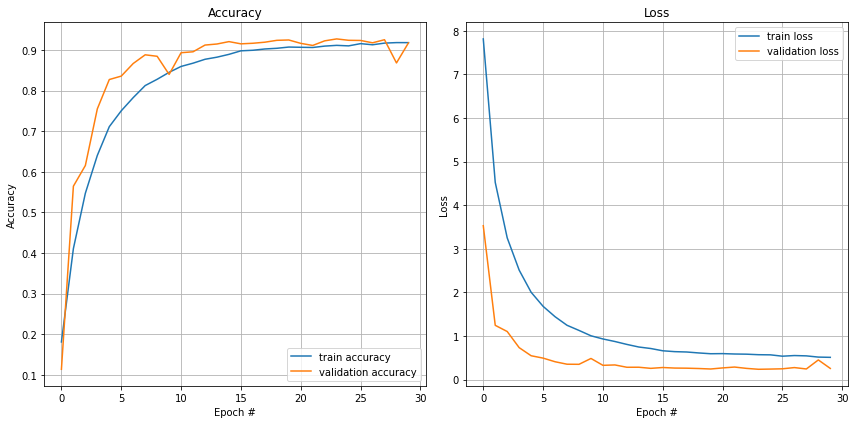

In [21]:
display_learning_curves(H)

### Prediction script

In [28]:
args = {
    "model": "output/trafficsignnet.model",
    "images": "gtsrb-german-traffic-sign/Test",
    "examples": "examples"
}

In [29]:
# load model
model = load_model(args["model"])

# load label names
with open("signnames.csv", "r") as f:
    label_names = f.read().strip().split("\n")[1:]
    label_names = [l.split(",")[1] for l in label_names]

# grab paths to input images, shuffle, and grab a sample
image_paths = list(paths.list_images(args["images"]))
random.shuffle(image_paths)
image_paths = image_paths[:25]

In [30]:
# loop over image paths
for (i, image_path) in enumerate(image_paths):
    # load image
    image = io.imread(image_path)
    # resize image
    image = transform.resize(image, (32, 32))
    # apply CLAHE
    image = exposure.equalize_adapthist(image, clip_limit=0.1)

    # preprocess image by scaling to [0, 1]
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)

    # make predictions using CNN
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = label_names[j]

    # load image using opencv, resize it, and draw label
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=128)
    cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # save image to disk
    p = os.path.sep.join([args["examples"], f"{i}.png"])
    print(p)
    cv2.imwrite(p, image)

1/1 [==============================] - 0s 308ms/step
examples/0.png
1/1 [==============================] - 0s 32ms/step
examples/1.png
1/1 [==============================] - 0s 31ms/step
examples/2.png
1/1 [==============================] - 0s 29ms/step
examples/3.png
1/1 [==============================] - 0s 28ms/step
examples/4.png
1/1 [==============================] - 0s 36ms/step
examples/5.png
1/1 [==============================] - 0s 30ms/step
examples/6.png
1/1 [==============================] - 0s 29ms/step
examples/7.png
1/1 [==============================] - 0s 37ms/step
examples/8.png
1/1 [==============================] - 0s 31ms/step
examples/9.png
1/1 [==============================] - 0s 36ms/step
examples/10.png
1/1 [==============================] - 0s 39ms/step
examples/11.png
1/1 [==============================] - 0s 42ms/step
examples/12.png
1/1 [==============================] - 0s 35ms/step
examples/13.png
1/1 [==============================] - 0s 21ms/step
examp